In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [99]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [101]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [102]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables 
Base.prepare(engine, reflect=True)
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [103]:
Base.classes.measurement

sqlalchemy.ext.automap.measurement

In [104]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [105]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [106]:
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [107]:
columns=inspector.get_columns('measurement')

In [108]:
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [109]:
for col in columns:
    print (col['name'],col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [110]:
session.query(Measurement.date).limit(10).all()

[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06'),
 ('2010-01-07'),
 ('2010-01-08'),
 ('2010-01-09'),
 ('2010-01-10'),
 ('2010-01-11')]

# Exploratory Precipitation Analysis

In [111]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23')

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
meas_columns = inspector.get_columns('measurement')
for column in meas_columns:
    print(column["name"], column["type"])

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores
meas_query = engine.execute('SELECT date , prcp FROM measurement').fetchall()
# meas_query


# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(meas_query)
measurement_df = measurement_df.rename(columns={0: 'date', 1: 'prcp'})
measurement_df['date'] =  pd.to_datetime(measurement_df['date'], format='%Y-%m-%d')
measurement_df.head()
mask = (measurement_df['date'] > '2016-08-23') & (measurement_df['date'] <= '2017-08-23')
measurement_df_1year = measurement_df.loc[mask]
measurement_df_1year = measurement_df_1year.set_index(['date'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [113]:
# measurement_df_1year.count()
measurement_df_1year.sort_index()
measurement_df_1year.head()
# Sort the dataframe by date

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


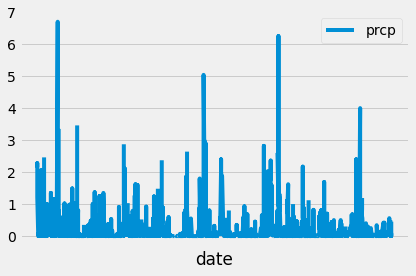

In [114]:
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df_1year.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

# Rotate the xticks for the dates

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off


In [115]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurement_df_1year.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [116]:
# Design a query to calculate the total number stations in the dataset
# stat_columns = inspector.get_columns('station')
# for column in stat_columns:
#     print(column["name"], column["type"])
    
stat_query = engine.execute('SELECT COUNT(station) FROM station').fetchall()
station_count = stat_query[0][0]

print(f'There are {station_count} stations in the dataset.')

There are 9 stations in the dataset.


In [117]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = [Measurement.station, 
       func.count(Measurement.station)]
activestations_query = session.query(*active_stations).\
    group_by(Measurement.station).\
    order_by(inspect(func.count(Measurement.station))).all()
activestations_query

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [118]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
USC281_query = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = "USC00519281"').fetchall()
USC281_stats = USC281_query[0]
USC281_stats

(54.0, 85.0, 71.66378066378067)

In [119]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC281_plotquery = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
USC281_plotquery

usc281_df = pd.DataFrame(USC281_plotquery)
usc281_df = usc281_df.rename(columns={0: 'date', 1: 'tobs'})
usc281_df.head()


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


<AxesSubplot:ylabel='Frequency'>

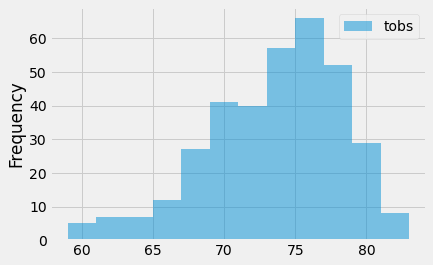

In [120]:
usc281_df.plot.hist(bins = 12, alpha=.5)
# plt.xticks([])
# plt.tight_layout()
# plt.show()

In [121]:
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [134]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

   ### Trip dates: 2017-08-01, 2017-08-07
    
print(calc_temps('2017-08-01', '2017-08-07'))

[(72.0, 79.25, 83.0)]


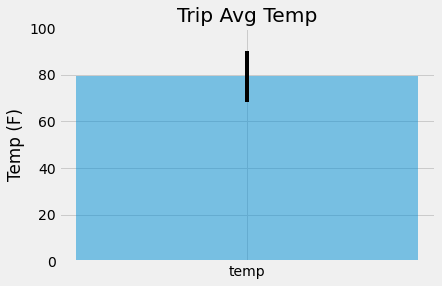

In [137]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_stats = calc_temps('2017-08-01', '2017-08-07')

trip_yaxis = trip_stats[0][1]
trip_min = trip_stats[0][0]
trip_max = trip_stats[0][2]
error = [trip_max - trip_min]

plt.bar("temp", trip_yaxis, alpha=.5, align = "center", yerr = error, width=.01)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 110, 20));

In [136]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'
sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()
for r in rainfall:
    print(r)

(7, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(6, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(3, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(3, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


# Temperature Difference Between June and December

In [125]:
#Hawaii is reputed to enjoy mild weather all year. 
#Is there a meaningful difference between the temperature in, for example, June and December?

#Identify the average temperature in June at all stations across all available years in the dataset.

query_june="06"

june_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_june).all()
june_avg

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [126]:
#Do the same for December temperature.

query_dec="12"


dec_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_dec ).all()
dec_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [127]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant.


# perform the t-test 
stats.ttest_ind(june_avg, dec_avg, equal_var=False)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

# Daily Normals

In [128]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [138]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = ["2018-02-28", "2018-03-01", "2018-03-02", "2018-03-03", "2018-03-04", "2018-03-05"]

# convert strings to datetime
date_list =[datetime.strptime(date, "%Y-%m-%d") for date in trip_dates]
date_list

# Stip off the year and save a list of %m-%d strings
dates = [date.strftime("%m-%d") for date in date_list]
dates

['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']

In [139]:
dates = ['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']
normals = [daily_normals(date) for date in dates]
normals

[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [140]:
# flatten the normals list
normal_list = [item for sublist in normals for item in sublist]
normal_list

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [141]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normal_list, columns=["tmin","tavg", "tmax"], index=trip_dates)
normals_df.index.name="date"
normals_df

,tmin,tavg,tmax
date,,,
2018-02-28,65.0,70.655172,80.0
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0


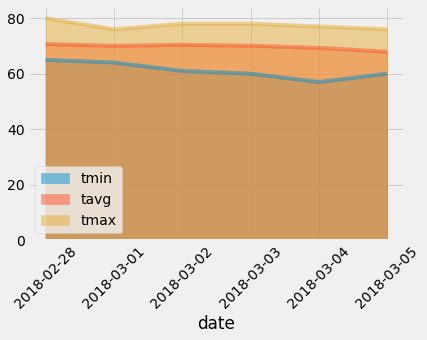

In [133]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()

# Close session

In [ ]:
# Close Session
session.close()